In [1]:
# activate the project environment
using Pkg; Pkg.activate(joinpath(@__DIR__, ".."));

  Activating project at `~/projects/julia-projects/dbscan`


In [2]:
using NearestNeighbors
using dbscan
using StaticArrays
using Dates
using CairoMakie
using LoggingExtras

In [3]:
fmt_logger = FormatLogger(stdout) do io, args
    # Write the module, level and message only
    println(io, args._module, " | ", "[", args.level, "] ", args.message)
end
debuglogger = MinLevelLogger(fmt_logger, Logging.Debug)

MinLevelLogger{FormatLogger, LogLevel}(FormatLogger(var"#11#12"(), VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(16) open, 0 bytes waiting)), VSCodeServer.io_send_callback), true), Debug)

In [4]:
with_logger(debuglogger) do
    @debug "test"
end

Main | [Debug] test


In [5]:
# points = [SVector{3}(rand(3)) for i in 1:1_000_000]
# points = map(i -> rand(3), 1:1_000_000)
# points = [rand(3) for _ in 1:1_000_000]
points = rand(SVector{2, Float64}, 10_000)

10000-element Vector{SVector{2, Float64}}:
 [0.4359194086040462, 0.14170995434459288]
 [0.9982152784934086, 0.7501453885746447]
 [0.2509162353407768, 0.5829853452666468]
 [0.41132048925989007, 0.7441177252078971]
 [0.18275707161373878, 0.6027329426967388]
 [0.2762361611536114, 0.8895332268301614]
 [0.8871171126320904, 0.49558826672962175]
 [0.5553556956478436, 0.6512488299786992]
 [0.8118025105547094, 0.39507369621831256]
 [0.004717967183899718, 0.5672099345758737]
 ⋮
 [0.22572838734836875, 0.27898170434057945]
 [0.19690769478781367, 0.09486001938380739]
 [0.5909094105487528, 0.7002295130946506]
 [0.9348739994917052, 0.9985621368229483]
 [0.723607615825168, 0.11494431520031512]
 [0.560889615574529, 0.9278548364206507]
 [0.7841501518224059, 0.1583392869340441]
 [0.7309837462409163, 0.6388841184976461]
 [0.1748661868266992, 0.786554517984185]

In [6]:
cluster_radius = 0.005
min_pts = 3

3

In [7]:
with_logger(debuglogger) do 
    clusters = dbscan.DBSCAN(points, cluster_radius, min_pts; n_chunks = 1)
end

dbscan | [Debug] performing range searches
dbscan | [Debug] starting thread 1
dbscan | [Debug] thread 1 completed
dbscan | [Debug] merged 1 edge clusters
dbscan | [Debug] updating labels to cluster roots
dbscan | [Debug] DBSCAN completed


ValueIterator for a Dict{Int64, Vector{Int64}} with 224 entries. Values:
  [1953, 2791, 6516, 9097]
  [2347, 3458, 5061, 6594]
  [3672, 4102, 7671, 9332]
  [2841, 3958, 5418, 5865, 7350, 9101]
  [2876, 3255, 5301, 7948, 9568]
  [1457, 2123, 2272, 6158, 9109]
  [2496, 4940, 7079, 9219]
  [232, 1871, 6772, 9965]
  [1619, 2667, 2744, 7505, 8171]
  [1528, 3575, 6691, 6937]
  [2934, 4128, 4284, 7416]
  [479, 3728, 5044, 6370]
  [4071, 4498, 6560, 7026]
  [544, 636, 5451, 8420]
  [1932, 3142, 7099, 8587, 9085]
  [4419, 4491, 6192, 8944]
  [23, 1028, 1256, 2975]
  [1085, 2434, 3583, 3964]
  [4812, 5449, 6216, 9407, 9576]
  ⋮

In [8]:
clusters = with_logger(debuglogger) do 
    dbscan.DBSCAN(points, cluster_radius, min_pts; n_chunks = 4)
end

dbscan | [Debug] performing range searches
dbscan | [Debug] starting thread 3
dbscan | [Debug] starting thread 1
dbscan | [Debug] starting thread 2
dbscan | [Debug] starting thread 4
dbscan | [Debug] thread 4 completed
dbscan | [Debug] thread 1 completed
dbscan | [Debug] thread 2 completed
dbscan | [Debug] thread 3 completed
dbscan | [Debug] merged 1 edge clusters
dbscan | [Debug] merged 2 edge clusters
dbscan | [Debug] merged 3 edge clusters
dbscan | [Debug] merged 4 edge clusters
dbscan | [Debug] updating labels to cluster roots
dbscan | [Debug] DBSCAN completed


ValueIterator for a Dict{Int64, Vector{Int64}} with 221 entries. Values:
  [1757, 2259, 4761, 6883, 7613]
  [491, 7011, 9466, 9699]
  [5947, 7385, 9140]
  [8037, 8743]
  [1709, 4241, 8344, 9538]
  [23, 1028, 1256, 2975]
  [217, 361, 1260, 2211, 4828, 7762, 9438]
  [4148, 4640, 8607]
  [4110, 8685, 8712, 8908]
  [754, 2349, 2455, 3941, 6806]
  [1431, 1799, 3778, 7882, 9018]
  [1387, 3704, 7845, 8013, 8477]
  [1121, 8608, 8754, 8937]
  [5065, 9802]
  [7453, 8639, 9133, 9898]
  [661, 675, 4150, 5691, 6455]
  [3245, 4930, 5458, 6519]
  [3774, 5118, 5351]
  [2934, 4128, 4284, 7416]
  ⋮

In [9]:
# for i in eachindex(clusters)
#     if clusters[i] != 0 
#         println(i, ' ', clusters[i])
#         j = dbscan.find_root(i, clusters)
#         clusters[i] = j
#     end
# end

In [10]:
# for i in eachindex(clusters)
#     if clusters[i] != 0 
#         println(i, ' ', clusters[i])
#     end
# end

In [30]:
minimum(map(length, clusters))

3

In [24]:
tree = KDTree(points)

KDTree{SVector{2, Float64}, Euclidean, Float64, SVector{2, Float64}}
  Number of points: 10000
  Dimensions: 2
  Metric: Euclidean(0.0)
  Reordered: true

In [25]:
# inrange(tree, points[263613], cluster_radius)

In [26]:
function draw_circle!(ax, x0, y0, r)
    t = 0:0.01:2pi
    x = x0 .+ r .* cos.(t)
    y = y0 .+ r .* sin.(t)
    lines!(ax, x, y; color = :black, alpha = 0.1)
end

draw_circle! (generic function with 1 method)

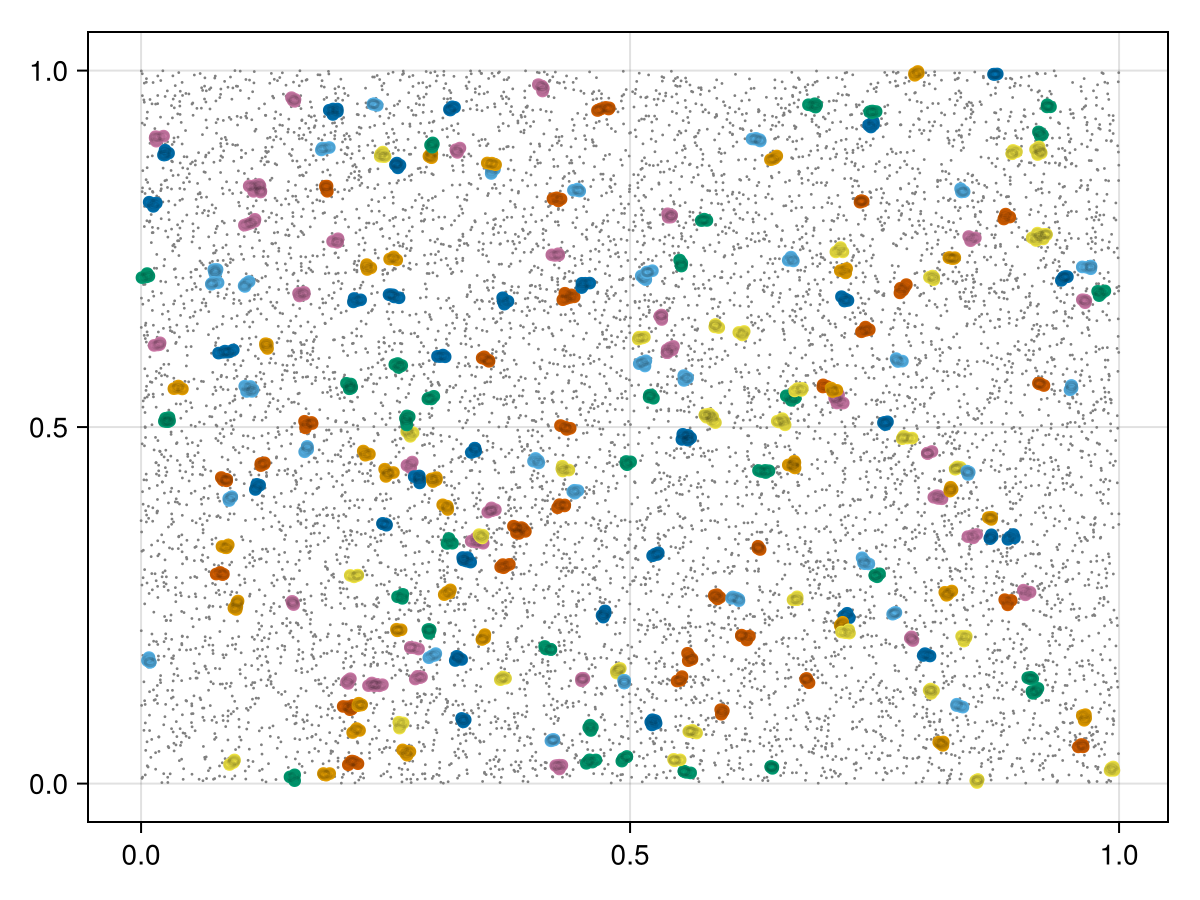

In [27]:
f = Figure()
ax = Axis(f[1, 1])

scatter!(points; color = :gray, markersize = 2.0)
for (id, cluster) in enumerate(clusters)
    scatter!(points[cluster])
    for (x0, y0) in points[cluster]
        draw_circle!(ax, x0, y0, cluster_radius)
    end
end

f

In [28]:
# wrap timings in a function to avoid global variables causing problems
function run_tests(N; n_chunks = 1)
    times = zeros(N)
    for i in 1:N
        points = rand(SVector{3, Float64}, 1_000_000)
        t0 = now()
        labels = dbscan.DBSCAN(points, 0.01, 3, n_chunks = n_chunks)
        tf = now()
        times[i] = (tf - t0).value / 1000
    end
    return times
end

run_tests (generic function with 1 method)

In [51]:
times_1 = run_tests(10; n_chunks = 1)

10-element Vector{Float64}:
 1.369
 1.411
 1.356
 1.261
 1.381
 1.327
 1.227
 1.355
 1.339
 1.305

In [52]:
times_2 = run_tests(10; n_chunks = 2)

10-element Vector{Float64}:
 1.067
 0.858
 0.876
 0.944
 0.886
 0.967
 0.848
 0.917
 0.845
 0.962

In [53]:
times_4 = run_tests(10; n_chunks = 4)

10-element Vector{Float64}:
 0.85
 0.819
 0.765
 0.821
 0.816
 0.682
 0.855
 0.923
 0.667
 0.783

In [ ]:
# smaller dataset for plotting